In [67]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../../dane.csv')

## from https://www.kaggle.com/competitions/spaceship-titanic/data

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence. 

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.  

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  

Destination - The planet the passenger will be debarking to.  

Age - The age of the passenger.  

VIP - Whether the passenger has paid for special VIP service during the voyage.  

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  

Name - The first and last names of the passenger.  

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# I will try to predict "Transported" variable by using the rest of variables

In [68]:
def create_scrollable_table(df):
    html = f'<div style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [69]:
data.shape

(8693, 14)

In [70]:
df_html = HTML(create_scrollable_table(data.head()))
display(df_html)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [71]:
# columns of data
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [72]:
# divide columns into numerical and categorical

numerical_features = data.copy().select_dtypes(include=[np.number])
categorical_features = data.copy().select_dtypes(include=[object, bool])

print(numerical_features.columns)
print(categorical_features.columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported'],
      dtype='object')


### Summary of categorical features

In [73]:
df_html = HTML(create_scrollable_table(categorical_features.describe().T))
display(df_html)

,count,unique,top,freq
PassengerId,8693,8693,5512_02,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Troya Schwardson,2
Transported,8693,2,True,4378


### Summary of numerical features

In [74]:
df_html = HTML(create_scrollable_table(numerical_features.describe().T))
display(df_html)

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


### Number of missing values of every feature

In [75]:
null_values = data.isnull().sum()
print(null_values)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


### I do not know yet what I should do with missing data. As for categorical, I think i will fill them with 'Unknown' label. When it comes to numerical, maybe I will impute them with mean / median

# Below i handle with categorical Cabin

### At first i will dive into this variable because it has many unique values and drawing count plot would be absurd.   
### As we can see from data description, from Cabin we can take information about deck and side

In [76]:
import math
data['CabinDeck'] = data['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[0] if type(x) is str else 'Unknown')
data['CabinSide'] = data['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[2] if type(x) is str else 'Unknown')
data['CabinNum'] = data['Cabin'].apply(lambda x: (x or 'Unknown/Unknown/Unknown').split('/')[1] if type(x) is str else '-1')

# after the split Cabin is no more useful
data.drop(columns='Cabin', inplace=True)

# refresh categorical
categorical_features = data.copy().select_dtypes(include=[object, bool])

In [77]:
len(data['CabinNum'].unique())

1818

### I think the cabin num is useless because there to many cabin nums to say anything about 'Transported' but I will keep it at this moment.

# Below i handle with categorical Name

### Name is almost unique so it should be useless for making predictions.

In [78]:
data.drop(columns='Name', inplace=True)
categorical_features.drop(columns='Name', inplace=True)

### Below i plot counts of other categorical variables (aparat from ID because it is unique)

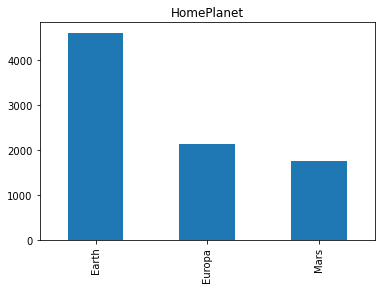

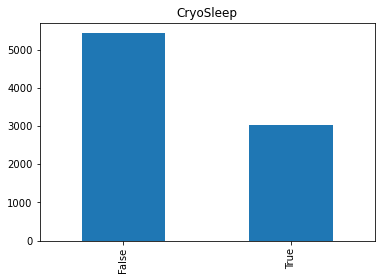

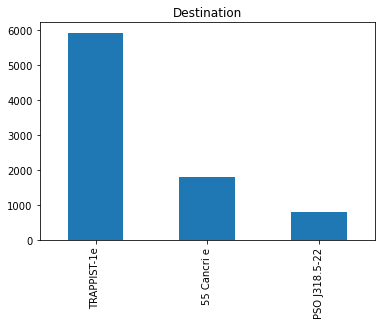

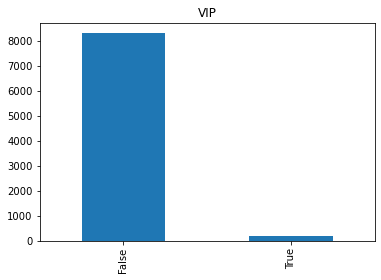

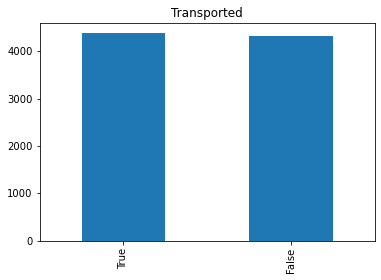

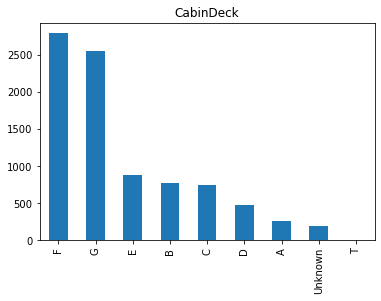

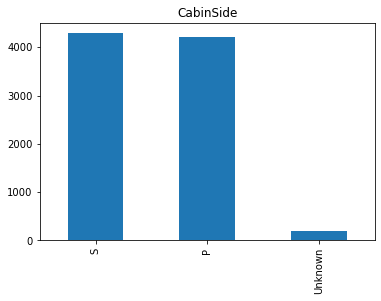

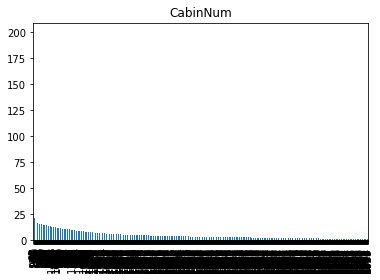

In [79]:
for col in categorical_features.drop(columns=['PassengerId']).columns:
    data[col].value_counts().plot(kind='bar', title=col)
    plt.show()

### Can we say something about connection between categorical independent variables and dependent variable "Transported" only by looking at plots below?

In [80]:
data['Transported'] = data['Transported'].astype(int)

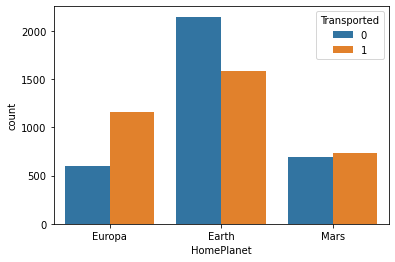

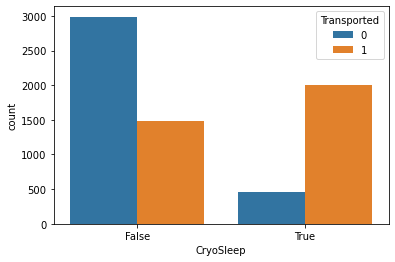

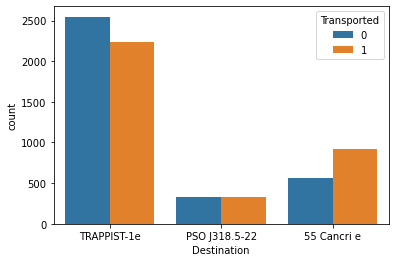

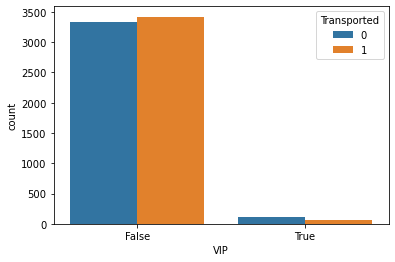

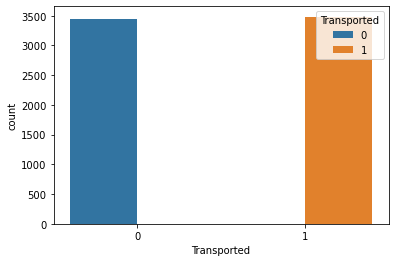

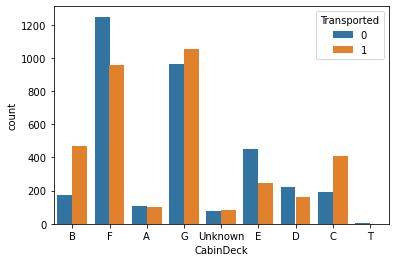

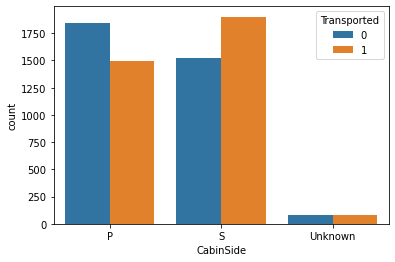

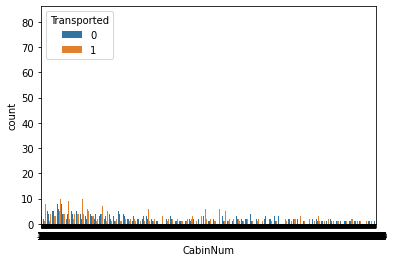

In [81]:

for col in categorical_features.drop(columns=['PassengerId']).columns:
    sns.countplot(data=data.dropna(), x=col, hue='Transported')
    plt.show()

### Conclusion: Most of the people who had CryoSleep were not transported while most of the people who did not have CryoSleep were transported

### What chi-squared test say about connection between dependent variables and "Transported"?

In [82]:
from scipy.stats import chi2_contingency

for col in categorical_features.drop(columns=['PassengerId']).columns: 
    ch2, p, _, _ = chi2_contingency(pd.crosstab(data[col], data['Transported']))
    print(f'{col}, p-value = {p}')
    if p < 0.05:
        print(f'{col} has a siginificant relationship with TRANSPORTED variable')
    else:
        print(f'There is not significant relationship between {col} and TRANSPORTED')
    print("*********************************")

HomePlanet, p-value = 2.809059985251311e-71
HomePlanet has a siginificant relationship with TRANSPORTED variable
*********************************
CryoSleep, p-value = 0.0
CryoSleep has a siginificant relationship with TRANSPORTED variable
*********************************
Destination, p-value = 7.892901466137099e-24
Destination has a siginificant relationship with TRANSPORTED variable
*********************************
VIP, p-value = 0.0006804064556968345
VIP has a siginificant relationship with TRANSPORTED variable
*********************************
Transported, p-value = 0.0
Transported has a siginificant relationship with TRANSPORTED variable
*********************************
CabinDeck, p-value = 8.3524884387207e-80
CabinDeck has a siginificant relationship with TRANSPORTED variable
*********************************
CabinSide, p-value = 1.3690336728997437e-20
CabinSide has a siginificant relationship with TRANSPORTED variable
*********************************
CabinNum, p-value = 0.00

### Filling missing categorical values

In [83]:
data[categorical_features.columns].isna().sum()

PassengerId      0
HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
Transported      0
CabinDeck        0
CabinSide        0
CabinNum         0
dtype: int64

In [84]:
data[categorical_features.drop(columns=['VIP', 'CryoSleep']).columns] = data[categorical_features.drop(columns=['VIP', 'CryoSleep']).columns].fillna('Unknown')

### VIPS and CryoSleep are boolean values. I will impute VIPS with False as most of the VIPS are False. I do no know what to do with CryoSleep, but just for simplicity lets impute it also with False

In [85]:
data['VIP'] = data['VIP'].fillna(False)
data['CryoSleep'] = data['CryoSleep'].fillna(False)

## Numerical variables - histograms

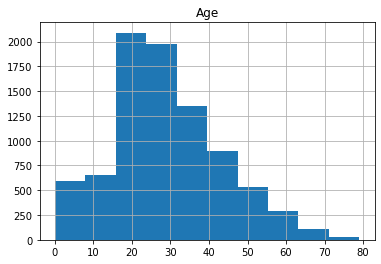

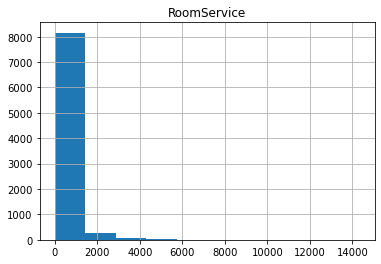

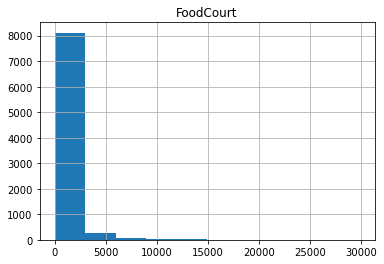

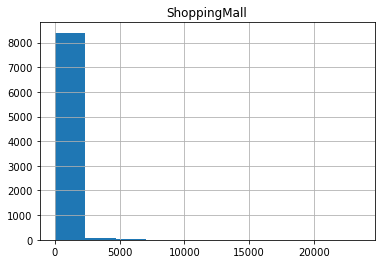

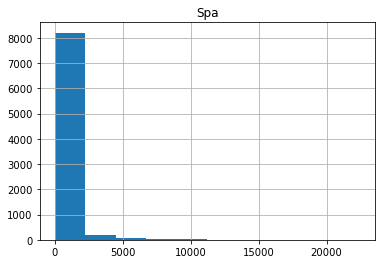

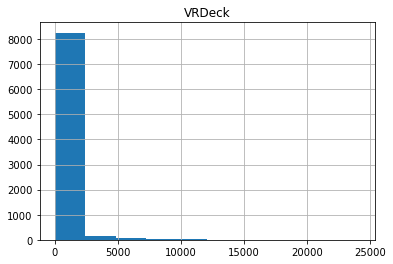

In [86]:
for col in numerical_features.columns:
    data[col].hist()
    plt.title(col)
    plt.show()

In [87]:
for col in numerical_features.columns:
    print(col, len(data[data[col] == 0]))

Age 178
RoomService 5577
FoodCourt 5456
ShoppingMall 5587
Spa 5324
VRDeck 5495


### There are many people who does not use at least one of the paid option. Instead of using this numerical columns maybe it would be more useful to transform it into binomial variable: 'does_he_paid_for_[option]' with values 1 or 0.
### Which may be atypical, there are ages = 0. I will ignore that fact (maybe these are some infants?)

In [88]:
df_html = HTML(create_scrollable_table(numerical_features.describe().T))
display(df_html)

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


### I will fill missing values with median

In [89]:
data[numerical_features.columns] = data[numerical_features.columns].fillna(data[numerical_features.columns].median())


In [90]:
c = numerical_features.corr()
print(c)

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   

                VRDeck  
Age           0.101007  
RoomService  -0.019581  
FoodCourt     0.227995  
ShoppingMall -0.007322  
Spa           0.153821  
VRDeck        1.000000  


<AxesSubplot:>

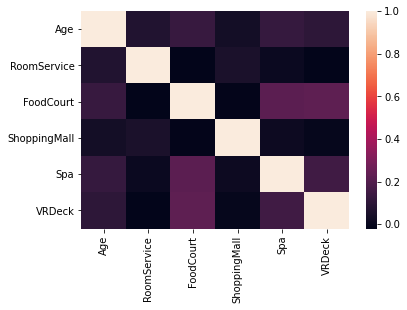

In [91]:
sns.heatmap(c)

### there does not seem to be correlation between any of the numerical variables (so there will be no problem inputing all numerical variables to a potencial model).

In [92]:
data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
CabinDeck       0
CabinSide       0
CabinNum        0
dtype: int64

### Model building

In [93]:
df_html = HTML(create_scrollable_table(data.head()))
display(df_html)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide,CabinNum
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,P,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,S,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,A,S,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,S,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,S,1


### I will convert VIP and CryoSleep into 0, 1 from False, True

In [94]:
data[['CryoSleep', 'VIP']] = data[['CryoSleep', 'VIP']].astype('int32') 

In [95]:
# Eventually I drop CabinNum
data_r = data.drop(columns='CabinNum')

# create dummy variables
data_r_dum = pd.get_dummies(data_r.drop(columns='PassengerId'))

In [96]:
data_r_dum.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_Unknown', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'Destination_Unknown', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C',
       'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G',
       'CabinDeck_T', 'CabinDeck_Unknown', 'CabinSide_P', 'CabinSide_S',
       'CabinSide_Unknown'],
      dtype='object')

In [97]:
from sklearn.model_selection import train_test_split

X = data_r_dum.drop(columns=['Transported'])
y = data_r_dum['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [98]:
# testing 6 different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=17),
    'RandomForestClassifier': RandomForestClassifier(random_state=17),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=17),
    'svm': svm.SVC(),
    'GaussianNB': GaussianNB()
}

In [99]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

for model_name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    
    print(f'{model_name}: Accuracy: {acc}, f1-score: {f1}')
    

LogisticRegression: Accuracy: 0.7902483900643974, f1-score: 0.7899639736298156
DecisionTreeClassifier: Accuracy: 0.7511499540018399, f1-score: 0.7510698438331723
RandomForestClassifier: Accuracy: 0.7953081876724931, f1-score: 0.7952353587979497
GradientBoostingClassifier: Accuracy: 0.8114075436982521, f1-score: 0.8110076679142613
svm: Accuracy: 0.7994480220791168, f1-score: 0.7972960372960374
GaussianNB: Accuracy: 0.7608095676172953, f1-score: 0.7545934493418083


### What also could be done here?
- models parameters tuning  
- I think I should apply imputing means (which i did for all numerical cols) only on X_train and then mean from X_train assign to X_test (isn't it called data leakage?). 

### I would like to check one more thing.
From the description we know that:   
*PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always*

#### Does people from the same group were transported simultanously?  
#### Is not being alone in a group has impact on being transported?


In [100]:
data['gggg'] = data['PassengerId'].apply(lambda x: x[0:4])

In [101]:
tab = pd.pivot_table(data, index='gggg',values='PassengerId', columns='Transported', aggfunc='count')
df_html = HTML(create_scrollable_table(tab))
display(df_html)

Transported,0,1
gggg,,
0001,1.0,NaN
0002,NaN,1.0
0003,2.0,NaN
0004,NaN,1.0
0005,NaN,1.0
0006,NaN,2.0
0007,NaN,1.0
0008,NaN,3.0
0009,NaN,1.0


In [102]:
tab = tab.fillna(0)

In [103]:
df_tab = tab.reset_index()

In [104]:
df_tab = df_tab.rename(columns={0: "value_0", 1: "value_1"})

### df_tab represents a dataframe which rows indicates a group and counts of people within the group who were transported or not

In [105]:
df_tab.head()

Transported,gggg,value_0,value_1
0,0001,1.0,0.0
1,0002,0.0,1.0
2,0003,2.0,0.0
3,0004,0.0,1.0
4,0005,0.0,1.0


In [106]:
df_tab['total'] = df_tab['value_0'] + df_tab['value_1']
df_mult_groups = df_tab[df_tab['value_0'] + df_tab['value_1'] > 1]
transported_simult = df_mult_groups[
    ((df_mult_groups['value_0'] == 0) 
    & 
    (df_mult_groups['value_1'] > 0))
    | 
    ((df_mult_groups['value_0'] > 0) 
    & 
    (df_mult_groups['value_1'] == 0))
]

In [107]:
print(f'There are {len(data)} passengers.')
print(f'Number of unique groups: {len(df_tab)}.')
print(f'Number of groups with more than one person: {len(df_mult_groups)}.')
print(f'Number of groups with more than one person where everybody were transported (or not) simultanously: {len(transported_simult)}.')

There are 8693 passengers.
Number of unique groups: 6217.
Number of groups with more than one person: 1412.
Number of groups with more than one person where everybody were transported (or not) simultanously: 615.


In [108]:
f_1 = df_tab['value_1'].sum() / df_tab['total'].sum()
f_2 = df_mult_groups['value_1'].sum() / df_mult_groups['total'].sum()
f_3 = transported_simult['value_1'].sum() / transported_simult['total'].sum()

In [109]:
print(f'Fraction of total transported: {f_1}')
print(f'Fraction of people transported who are not alone in their group: {f_2}')
print(f'Fraction of people transported whose the whole group were transp. or not: {f_3}')

Fraction of total transported: 0.5036236051995858
Fraction of people transported who are not alone in their group: 0.5668724279835391
Fraction of people transported whose the whole group were transp. or not: 0.6383275261324042


### Despite, in groups, fraction of people transported grows, it does not seem to be a significant change